In [1]:
# imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

#notebook settings
pd.set_option('display.max_columns', None)

from scipy.stats import uniform, randint

# building a pipeline to preprocess the data
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve, validation_curve, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import os

# File Loading

In [2]:
# Paths to feature files
train_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/processed test/prepared_claims_data_train_median.csv"
val_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/processed test/prepared_claims_data_val_median.csv"
test_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/processed test/prepared_claims_data_test_median.csv"

# Paths to target files
ytrain_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/processed test/y_train_encoded_median.csv"
yval_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/processed test/y_val_encoded_median.csv"
ytest_path = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/processed test/y_test_encoded_median.csv"

# Load the feature datasets
X_train = pd.read_csv(train_path)
X_val = pd.read_csv(val_path)
X_test = pd.read_csv(test_path)

# Load the target datasets
y_train = pd.read_csv(ytrain_path)
y_val = pd.read_csv(yval_path)
y_test = pd.read_csv(ytest_path)

# Inspect loaded data
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)


X_train shape: (346576, 42) y_train shape: (346576, 1)
X_val shape: (91844, 42) y_val shape: (91844, 1)
X_test shape: (114806, 42) y_test shape: (114806, 1)


/var/folders/2m/t2s2zdt15tgd3q3dmyd7y88r0000gn/T/ipykernel_78335/3407831173.py:14: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  X_test = pd.read_csv(test_path)


In [3]:
print(X_train.columns)


Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'Carrier Name', 'Carrier Type', 'Claim Identifier', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'Gender',
       'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Description', 'Zip Code', 'Number of Dependents',
       'Cause Injury Category', 'Nature of Injury Category',
       'Body Part Category', 'Age_Group', 'Wage_Group', 'Carrier Name Grouped',
       'Lag_Time', 'Accident_to_C2_Lag', 'Accident Date_Year',
       'Accident Date_Month', 'Assembly Date_Month', 'Assembly Date_Day',
       'C-2 Date_Year', 'C-2 Date_Month', 'C-2 Date_Day', 'Accident_Month_Sin',
       'Accident_Month_Cos', 'Accident_Day', 'Assembly_Year',
       'Assembly_Month_Sin', 'Assembly_Month_Cos', 'Assembly_Day',
       'C-2_Month_Sin', 'C-2_Month_Cos', 'C-2_Day'],
      dtype='object')


In [4]:
y_train.head()

,Claim Injury Type
0,0.0
1,2.0
2,4.0
3,1.0
4,1.0


In [5]:
y_train.head()

,Claim Injury Type
0,0.0
1,2.0
2,4.0
3,1.0
4,1.0


# Encodings of the features

We decide to encode the variables as follows:
- __One-Hot Encoding:__ For variables with a small number of unique values (< 5); preferable because it treats each category independently and avoids introducing an artificial order.
- __Ordinal Encoding:__ For variables with a natural order or numeric-like scale.

| **Variable**                     | **Encoding Type**       | **Reason**                                                                 |
|----------------------------------|-------------------------|-----------------------------------------------------------------------------|
| Age at Injury                    | None                   | Numerical variable; leave as-is.                                           |
| Attorney/Representative          | One-Hot                | Binary categorical (Yes/No).                                               |
| Average Weekly Wage              | None                   | Numerical variable; leave as-is.                                           |
| Carrier Type                     | One-Hot                | Nominal categorical; moderate cardinality.                                 |
| Claim Identifier                 | None                   | Unique identifier; leave as-is.                                            |
| County of Injury                 | One-Hot                | Nominal categorical; One-Hot Encoding avoids unintended ordinal meaning.   |
| COVID-19 Indicator               | One-Hot                | Binary categorical (Yes/No).                                               |
| District Name                    | One-Hot                | Nominal categorical; One-Hot avoids ordinal meaning.                       |
| Gender                           | One-Hot                | Binary categorical (Male/Female/Other).                                    |
| Industry Code Description        | One-Hot                | Nominal categorical; One-Hot avoids ordinal assumptions.                   |
| Medical Fee Region               | One-Hot                | Nominal categorical (regions); One-Hot avoids unintended ordinal meaning.  |
| Number of Dependents             | None                   | Numerical variable; leave as-is.                                           |
| Lag_Time                         | None                   | Numerical variable; leave as-is.                                           |
| Accident_to_C2_Lag               | None                   | Numerical variable; leave as-is.                                           |
| Accident Date_Year               | None                   | Numerical variable; leave as-is.                                           |
| Accident Date_Month              | One-Hot                | Nominal categorical; avoids unintended ordinal meaning.                    |
| Accident Date_Day                | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Assembly Date_Month              | One-Hot                | Nominal categorical; avoids unintended ordinal meaning.                    |
| Assembly Date_Day                | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| C-2 Date_Year                    | None                   | Numerical variable; leave as-is.                                           |
| C-2 Date_Month                   | One-Hot                | Nominal categorical; avoids unintended ordinal meaning.                    |
| C-2 Date_Day                     | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Accident_Month_Sin               | None                   | Already processed as cyclical; leave as-is.                                |
| Accident_Month_Cos               | None                   | Already processed as cyclical; leave as-is.                                |
| Accident_Day                     | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Assembly_Year                    | None                   | Numerical variable; leave as-is.                                           |
| Assembly_Month_Sin               | None                   | Already processed as cyclical; leave as-is.                                |
| Assembly_Month_Cos               | None                   | Already processed as cyclical; leave as-is.                                |
| Assembly_Day                     | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| C-2_Month_Sin                    | None                   | Already processed as cyclical; leave as-is.                                |
| C-2_Month_Cos                    | None                   | Already processed as cyclical; leave as-is.                                |
| C-2_Day                          | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Cause Injury Category            | One-Hot                | Nominal categorical; avoids unintended ordinal meaning.                    |
| Nature of Injury Category        | One-Hot                | Nominal categorical; avoids unintended ordinal meaning.                    |
| Body Part Category               | One-Hot                | Nominal categorical; avoids unintended ordinal meaning.                    |
| Region                           | One-Hot                | Nominal categorical; avoids unintended ordinal meaning.                    |
| State                            | One-Hot                | Nominal categorical; avoids unintended ordinal meaning.                    |
| Age_Group                        | Ordinal                | Categorical with inherent order (e.g., Teen, Adult).                       |
| Wage_Group                       | Ordinal                | Categorical with inherent order (e.g., Low, Medium, High).                 |
| Carrier Name Grouped             | One-Hot                | Nominal categorical; avoids unintended ordinal meaning.                    |

In [6]:
X_train['Region'] = X_train['Zip Code'].astype(str).str[0]
X_val['Region'] = X_val['Zip Code'].astype(str).str[0]
X_test['Region'] = X_test['Zip Code'].astype(str).str[0]


In [7]:
X_train['State'] = X_train['Zip Code'].astype(str).str[:2]
X_val['State'] = X_val['Zip Code'].astype(str).str[:2]
X_test['State'] = X_test['Zip Code'].astype(str).str[:2]


In [8]:
X_train = X_train.drop(columns=[ 'Carrier Name', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code'])
X_val = X_val.drop(columns=[ 'Carrier Name', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code'])
X_test = X_test.drop(columns=['Carrier Name', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code'])

## Scalling

In [9]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Separate numerical and categorical columns
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X_train.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Scale numerical features
scaler = StandardScaler()
X_train_scaled_numerical = scaler.fit_transform(X_train[numerical_columns])
X_val_scaled_numerical = scaler.transform(X_val[numerical_columns])
X_test_scaled_numerical = scaler.transform(X_test[numerical_columns])

# Convert scaled numerical data back to DataFrame
X_train_scaled_numerical = pd.DataFrame(X_train_scaled_numerical, columns=numerical_columns, index=X_train.index)
X_val_scaled_numerical = pd.DataFrame(X_val_scaled_numerical, columns=numerical_columns, index=X_val.index)
X_test_scaled_numerical = pd.DataFrame(X_test_scaled_numerical, columns=numerical_columns, index=X_test.index)



In [10]:
X_train_scaled_numerical.head()

,Age at Injury,Average Weekly Wage,Claim Identifier,Number of Dependents,Lag_Time,Accident_to_C2_Lag,Accident Date_Year,Accident Date_Month,Assembly Date_Month,Assembly Date_Day,C-2 Date_Year,C-2 Date_Month,C-2 Date_Day,Accident_Month_Sin,Accident_Month_Cos,Accident_Day,Assembly_Year,Assembly_Month_Sin,Assembly_Month_Cos,Assembly_Day,C-2_Month_Sin,C-2_Month_Cos,C-2_Day
0,-1.182536,-0.632462,0.880103,-1.502617,0.887462,0.039054,1.185679,-1.585308,-0.722808,-0.700776,-0.090365,0.149348,-0.099383,0.719264,1.217411,-0.275587,1.167647,1.234900,-0.712083,-0.700776,0.015589,-0.002609,-0.099383
1,1.212683,0.809764,0.116911,1.496494,0.153694,0.132213,0.043169,0.434498,0.728991,-0.700776,-0.090365,0.735702,-0.785048,-1.205401,-0.722067,-0.826830,-0.067156,-1.387530,-0.000347,-0.700776,-1.402742,-0.002609,-0.785048
2,-1.255119,1.316476,0.388915,1.496494,0.407813,0.389202,0.043169,1.300129,1.309710,1.383737,-0.090365,1.322056,1.271948,-0.689689,1.217411,1.378143,-0.067156,-0.684852,1.232417,1.383737,-0.693576,1.245486,1.271948
3,-1.255119,-0.632462,0.884552,1.496494,0.890639,0.877480,1.185679,-0.719677,-0.722808,-0.005938,1.153264,-0.730183,-0.099383,1.234976,-0.722067,1.929386,1.167647,1.234900,-0.712083,-0.005938,1.243900,-0.723197,-0.099383
4,-1.690613,-0.632462,-1.037381,-1.002766,-1.027959,-1.062785,-1.099342,0.434498,0.438631,-1.395614,-1.333994,0.442525,-1.470714,-1.205401,-0.722067,0.826900,-1.301960,-1.199248,-0.712083,-1.395614,-1.212721,-0.723197,-1.470714


## Verificaton of the scalling of the data

In [11]:
# Verify scaled data
print("Scaled X_train mean:",X_train_scaled_numerical.mean(axis=0))
print("Scaled X_train std:", X_train_scaled_numerical.std(axis=0))

Scaled X_train mean: Age at Injury           3.380745e-17
Average Weekly Wage     1.609493e-16
Claim Identifier       -1.694760e-15
Number of Dependents   -1.269881e-16
Lag_Time                4.920798e-15
Accident_to_C2_Lag      4.811277e-15
Accident Date_Year      4.504731e-14
Accident Date_Month     1.914867e-17
Assembly Date_Month     5.115196e-17
Assembly Date_Day       1.615746e-16
C-2 Date_Year          -6.826357e-14
C-2 Date_Month         -7.064916e-17
C-2 Date_Day           -7.733274e-17
Accident_Month_Sin     -3.852286e-17
Accident_Month_Cos     -5.057791e-17
Accident_Day            1.126163e-16
Assembly_Year           1.910262e-14
Assembly_Month_Sin      3.485304e-17
Assembly_Month_Cos      1.828759e-17
Assembly_Day            1.615746e-16
C-2_Month_Sin          -1.305964e-17
C-2_Month_Cos           5.671819e-17
C-2_Day                -7.733274e-17
dtype: float64
Scaled X_train std: Age at Injury           1.000001
Average Weekly Wage     1.000001
Claim Identifier        1.0

In [12]:
#Checking the number of features after Scalling
num_features2 = X_train_scaled_numerical.shape[1]
print(f"Number of features after encoding: {num_features2}")

Number of features after encoding: 23


## Verificaton of the mapping of the target variable

In [13]:
# Ensure `y_train`, `y_val`, and `y_test` are Series
if isinstance(y_train, pd.DataFrame):
    if 'Claim Injury Type' in y_train.columns:  # Replace with actual column name
        y_train = y_train['Claim Injury Type']
        y_val = y_val['Claim Injury Type']
        y_test = y_test['Claim Injury Type']
    else:
        # If no explicit column name, take the first column
        y_train = y_train.iloc[:, 0]
        y_val = y_val.iloc[:, 0]
        y_test = y_test.iloc[:, 0]

# Verify they are Series
print("y_train type (after extraction):", type(y_train))
print("y_val type (after extraction):", type(y_val))
print("y_test type (after extraction):", type(y_test))


# Verify the mapping
print("Mapped y_train unique values:", y_train.unique())
print("Mapped y_val unique values:", y_val.unique())
print("Mapped y_test unique values:", y_test.unique())

y_train type (after extraction): <class 'pandas.core.series.Series'>
y_val type (after extraction): <class 'pandas.core.series.Series'>
y_test type (after extraction): <class 'pandas.core.series.Series'>
Mapped y_train unique values: [0. 2. 4. 1. 3. 5. 7. 6.]
Mapped y_val unique values: [1. 3. 4. 2. 0. 5. 6. 7.]
Mapped y_test unique values: [4. 3. 2. 1. 0. 5. 7. 6.]


# Feature Selection Pipeline

## Correlation Matrix

In [14]:
correlation_matrix= X_train_scaled_numerical.corr(method='spearman')

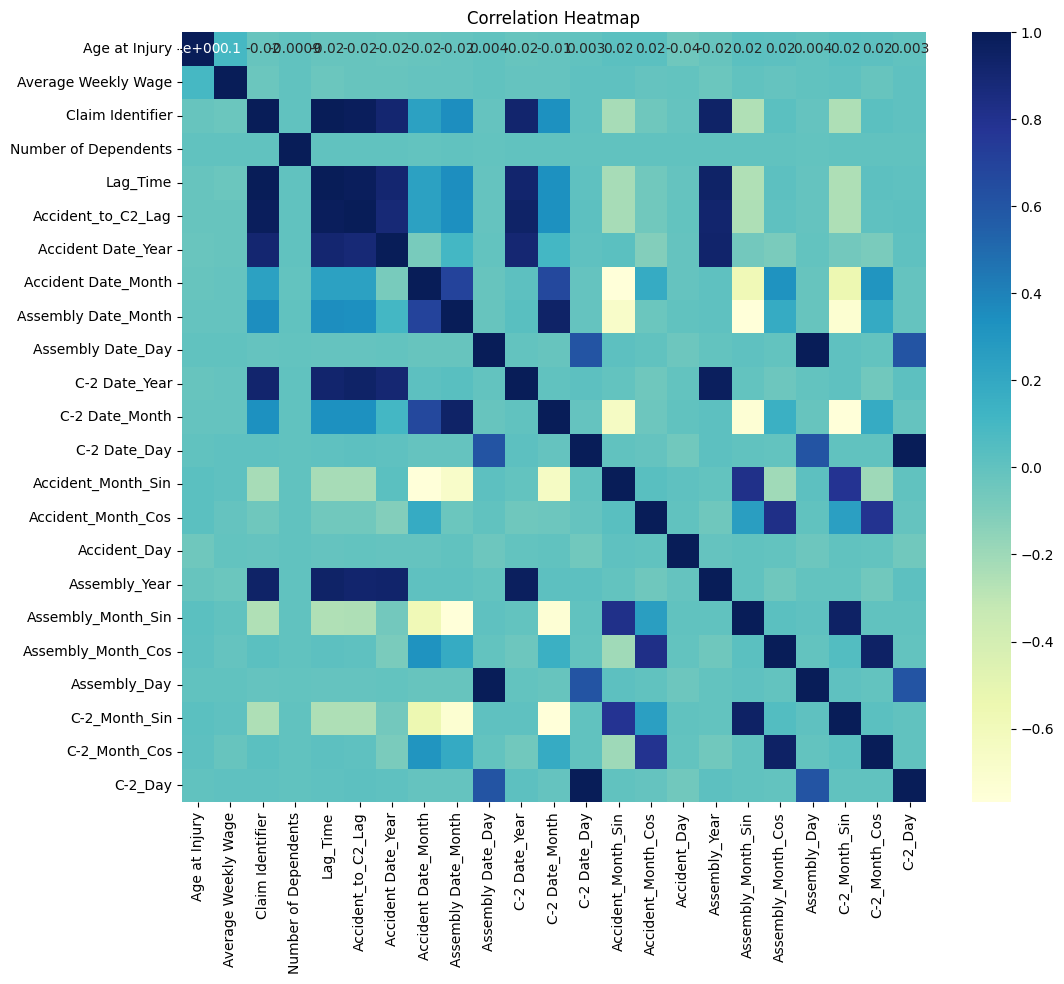

In [15]:
# heatmap 
def cor_heatmap(data):
    cor_matrix = data.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(data=cor_matrix, annot=True, cmap= 'YlGnBu' , fmt='.1')
    plt.title("Correlation Heatmap")
    plt.show()

cor_heatmap(X_train_scaled_numerical)

## Identify High Correlated Pairs - Pearson Correlation

In [35]:
# Step 2: Identify Highly Correlated Pairs
threshold = 0.8  # Correlation threshold
high_corr_pairs = []
to_discard_correlation = set()

for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        if col != row and abs(correlation_matrix.loc[row, col]) > threshold:
            pair = tuple(sorted([row, col]))  # Ensure pairs are unique
            if pair not in high_corr_pairs:
                high_corr_pairs.append(pair)
                # Add one side of the pair to discard list
                to_discard_correlation.add(pair[1])

# Step 3: Create List of Variables to Keep
variables_to_keep_correlation = [col for col in X_train_scaled_numerical.columns if col not in to_discard_correlation]

# Step 4: Display Results
print("\n--- Highly Correlated Pairs (|correlation| > 0.8) ---")
for pair in high_corr_pairs:
    print(f"{pair[0]} <--> {pair[1]}")

print("\n--- Variables to Discard ---")
print(to_discard_correlation)

print("\n--- Variables to Keep ---")
print(variables_to_keep_correlation)

# Optional: Convert Results to Lists
variables_to_discard = list(to_discard_correlation)
variables_to_keep = list(variables_to_keep_correlation)

# Step 4: Create DataFrame with Selected Variables
selected_variables_df = X_train_scaled_numerical[variables_to_keep_correlation]


--- Highly Correlated Pairs (|correlation| > 0.8) ---
Claim Identifier <--> Lag_Time
Accident_to_C2_Lag <--> Claim Identifier
Accident Date_Year <--> Claim Identifier
C-2 Date_Year <--> Claim Identifier
Assembly_Year <--> Claim Identifier
Accident_to_C2_Lag <--> Lag_Time
Accident Date_Year <--> Lag_Time
C-2 Date_Year <--> Lag_Time
Assembly_Year <--> Lag_Time
Accident Date_Year <--> Accident_to_C2_Lag
Accident_to_C2_Lag <--> C-2 Date_Year
Accident_to_C2_Lag <--> Assembly_Year
Accident Date_Year <--> C-2 Date_Year
Accident Date_Year <--> Assembly_Year
Assembly Date_Month <--> C-2 Date_Month
Assembly Date_Day <--> Assembly_Day
Assembly_Year <--> C-2 Date_Year
C-2 Date_Day <--> C-2_Day
Accident_Month_Sin <--> Assembly_Month_Sin
Accident_Month_Cos <--> Assembly_Month_Cos
Assembly_Month_Sin <--> C-2_Month_Sin
Assembly_Month_Cos <--> C-2_Month_Cos

--- Variables to Discard ---
{'C-2_Day', 'Claim Identifier', 'C-2_Month_Sin', 'Accident_to_C2_Lag', 'C-2 Date_Year', 'Assembly_Day', 'Assembly_Mo

## RandomForest Regressor

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Initialize 'to_exclude' if not already defined
to_exclude = set()  # Or use an empty list: to_exclude = []

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(selected_variables_df, y_train.values.ravel())

# Extract Feature Importances
feature_importances = pd.Series(rf.feature_importances_, index= selected_variables_df.columns)

# Filter Remaining Features
remaining_features = [f for f in selected_variables_df.columns if f not in to_exclude]

# Select Top 20 Features
top_features = feature_importances[remaining_features].nlargest(20).index.tolist()

# Output Final Results
print("\n--- Final Feature Selection ---")
print(f"Number of Remaining Features: {len(remaining_features)}")
print(f"Top 20 Features by Random Forest: {top_features}")

print("\n--- Final Selected Features ---")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature}")


--- Final Feature Selection ---
Number of Remaining Features: 11
Top 20 Features by Random Forest: ['Average Weekly Wage', 'Age at Injury', 'Number of Dependents', 'Accident_Day', 'Assembly Date_Month', 'Accident Date_Year', 'Assembly Date_Day', 'C-2 Date_Day', 'Accident Date_Month', 'Accident_Month_Sin', 'Accident_Month_Cos']

--- Final Selected Features ---
1. Average Weekly Wage
2. Age at Injury
3. Number of Dependents
4. Accident_Day
5. Assembly Date_Month
6. Accident Date_Year
7. Assembly Date_Day
8. C-2 Date_Day
9. Accident Date_Month
10. Accident_Month_Sin
11. Accident_Month_Cos


## Lasso Feature Importance 

Optimal alpha: 0.0008313552403081629


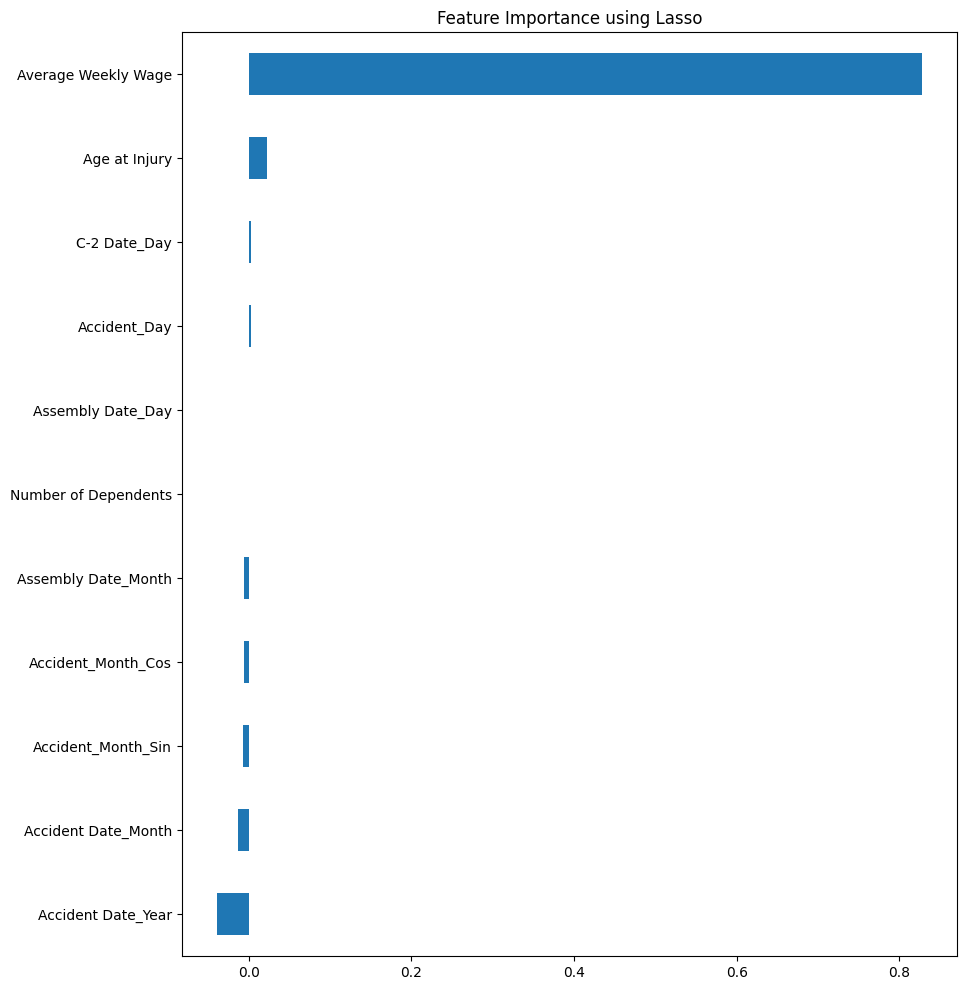

Features with non-zero coefficients: ['Age at Injury', 'Average Weekly Wage', 'Accident Date_Year', 'Accident Date_Month', 'Assembly Date_Month', 'C-2 Date_Day', 'Accident_Month_Sin', 'Accident_Month_Cos', 'Accident_Day']
/Features with zero coefficients: ['Number of Dependents', 'Assembly Date_Day']


In [37]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Automatically tune alpha
lasso_cv = LassoCV(cv=5)  # 5-fold cross-validation
lasso_cv.fit(selected_variables_df, y_train)

# Optimal alpha
best_alpha = lasso_cv.alpha_
print("Optimal alpha:", best_alpha)

# Fit Lasso with the optimal alpha
lasso = Lasso(alpha=best_alpha)
lasso.fit(selected_variables_df, y_train)

coef = pd.Series(lasso.coef_, index = selected_variables_df.columns)

# Sort coefficients by importance
coef_sorted = coef.sort_values()

# Plot feature importance
def plot_importance(coef, model_name):
    plt.figure(figsize=(10, 12))
    coef.plot(kind="barh")
    plt.title(f"Feature Importance using {model_name}")
    plt.show()

plot_importance(coef_sorted, "Lasso")

important_features = coef[coef != 0].index.tolist()
not_important_features = coef[coef == 0].index.tolist()
print("Features with non-zero coefficients:", important_features)
print("/Features with zero coefficients:", not_important_features)

## LASSO Regression

In [44]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Ensure the validation set has the same columns as the training set
X_val_filtered = X_val_scaled_numerical[selected_variables_df.columns]

# Train LassoCV
lasso = LassoCV(max_iter=5000, cv=5, random_state=42, alphas=np.logspace(-4, 1, 50))
lasso.fit(selected_variables_df, y_train)

# Predict on validation set
y_pred = lasso.predict(X_val_filtered)

# Evaluate model
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Print results
print(f"Optimal alpha: {lasso.alpha_}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")


Optimal alpha: 0.0001
Mean Squared Error: 167.0361
R^2 Score: -130.6247


## Chi-Squared 

In [30]:
import pandas as pd
from scipy import stats

def TestIndependence(X, y, var, alpha=0.05):
    """
    Performs a chi-squared test of independence for the variable X with the target y.
    
    Parameters:
    - X: A pandas Series or DataFrame column (categorical feature).
    - y: A pandas Series or DataFrame column (target variable).
    - var: String, name of the variable (used in the output message).
    - alpha: Significance level (default=0.05).
    
    Returns:
    - Boolean indicating whether the variable is important for prediction.
    """
    # Create contingency table
    dfObserved = pd.crosstab(y, X)
    
    # Perform chi-squared test
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    
    # Return True if the variable is important, otherwise False
    return p < alpha


# List to store important variables
important_variables_chi = []

# Loop through all categorical columns
for var in categorical_columns:
    if TestIndependence(X_train[var], y_train, var):
        important_variables_chi.append(var)

# Print the list of important variables
print("Important Variables:", important_variables_chi)

Important Variables: ['Attorney/Representative', 'Carrier Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender', 'Industry Code Description', 'Medical Fee Region', 'Cause Injury Category', 'Nature of Injury Category', 'Body Part Category', 'Age_Group', 'Wage_Group', 'Carrier Name Grouped', 'Region', 'State']


## Result List

In [48]:
from collections import Counter  # Import Counter

#features selected by each method
print("Correlation Method 1:", variables_to_keep_correlation)
print("Top Features:", top_features)
print("Top Features:", important_features)
print("Important Variables (Chi-squared):", important_variables_chi)

# Combine all numerical lists into one
all_methods = [
    variables_to_keep_correlation,
    top_features,
    important_features,
]

# Flatten all variables and count occurrences
variable_counts = Counter(var for method in all_methods for var in method)

# Calculate majority threshold
total_methods = len(all_methods)
majority_threshold = 2

# Keep variables with votes greater than or equal to the majority threshold
final_keep_set = sorted([var for var, count in variable_counts.items() if count >= majority_threshold])

# Print the final list of variables to keep
print(f"Total variables to keep: {len(final_keep_set)}")
print("Final List of Variables to Keep (Majority Vote):")
for feature in final_keep_set:
    print(f"- {feature}")

final_list = final_keep_set + important_variables_chi
print("Final list:", final_list)

Correlation Method 1: ['Age at Injury', 'Average Weekly Wage', 'Number of Dependents', 'Accident Date_Year', 'Accident Date_Month', 'Assembly Date_Month', 'Assembly Date_Day', 'C-2 Date_Day', 'Accident_Month_Sin', 'Accident_Month_Cos', 'Accident_Day']
Top Features: ['Average Weekly Wage', 'Age at Injury', 'Number of Dependents', 'Accident_Day', 'Assembly Date_Month', 'Accident Date_Year', 'Assembly Date_Day', 'C-2 Date_Day', 'Accident Date_Month', 'Accident_Month_Sin', 'Accident_Month_Cos']
Top Features: ['Age at Injury', 'Average Weekly Wage', 'Accident Date_Year', 'Accident Date_Month', 'Assembly Date_Month', 'C-2 Date_Day', 'Accident_Month_Sin', 'Accident_Month_Cos', 'Accident_Day']
Important Variables (Chi-squared): ['Attorney/Representative', 'Carrier Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender', 'Industry Code Description', 'Medical Fee Region', 'Cause Injury Category', 'Nature of Injury Category', 'Body Part Category', 'Age_Group', 'Wage_Group', 'Ca

In [49]:
selected_variables_df = X_train_scaled_numerical[final_keep_set] + X_train[important_variables_chi]

In [ ]:
import os
import pandas as pd
# Define the absolute path for saving files
processed_dir = "/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/1º Semestre/Apredizagem automática/project_data/processed test/"

# Ensure the directory exists
os.makedirs(processed_dir, exist_ok=True)

# Define file paths
train_file_path = os.path.join(processed_dir, 'X_train_featured.csv')
val_file_path = os.path.join(processed_dir, 'X_val_featured.csv')
test_file_path = os.path.join(processed_dir, 'X_test_featured.csv')

# Save the filtered datasets with the final features
X_train_lasso2.to_csv(train_file_path, index=True)  # Preserve original indices
X_val_lasso2.to_csv(val_file_path, index=True)     # Preserve original indices
X_test_lasso2.to_csv(test_file_path, index=True)   # Preserve original indices

# Print confirmation messages
print(f"Filtered training data saved to: {train_file_path}")
print(f"Filtered validation data saved to: {val_file_path}")
print(f"Filtered test data saved to: {test_file_path}")